# Beta Distribution with NGBoost

**Problem**: Regression on bounded (0, 1) outcomes - proportions, rates,
probabilities, fractions.

**When to use**:
- Click-through rate prediction: "this ad has a 3.2% CTR, 90% CI [2.1%, 4.5%]"
- Exam pass rates: predict what fraction of students will pass, per school
- Market share modeling: predict brand share as a proportion
- Manufacturing yield: fraction of non-defective items per batch

**What this notebook shows**: Using the built-in `Beta` distribution —
provide features and bounded (0,1) outcomes, get full predictive distributions
with quantiles, CDF, and calibrated prediction intervals.

In [1]:
import sys
sys.path.insert(0, '..')  # add project root so 'import ngboost' finds the package

In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import Beta

## 1. Generate synthetic data in (0, 1)

In [3]:
np.random.seed(42)
n_samples = 5000
n_features = 5

X = np.random.randn(n_samples, n_features)

# True alpha/beta depend on features
true_alpha = np.exp(0.5 + 1.8 * X[:, 0])
true_beta = np.exp(0.8 - 1.6 * X[:, 1])
Y = np.array([scipy.stats.beta.rvs(a, b) for a, b in zip(true_alpha, true_beta)])
Y = np.clip(Y, 1e-4, 1 - 1e-4)  # avoid exact 0 or 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y range: [{Y.min():.4f}, {Y.max():.4f}]")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [0.0001, 0.9999]
Train: 4000, Test: 1000


## 2. Train NGBoost

In [4]:
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_depth=6,
    splitter="best",
    random_state=None,
)
ngb = NGBRegressor(
    Dist=Beta,
    n_estimators=1000,
    learning_rate=0.01,
    Base=tree_learner,
    verbose=False,
    random_state=42,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 3. Predictions and parameters

In [5]:
# Point predictions
Y_pred = ngb.predict(X_test)

# Full predictive distributions
dists = ngb.pred_dist(X_test)

print("Estimated parameters (first 5 test samples):")
print(f"  alpha: {dists.alpha[:5].round(3)}")
print(f"  beta:  {dists.beta[:5].round(3)}")
print(f"\nPredicted mean (first 5): {Y_pred[:5].round(4)}")
print(f"Actual (first 5):          {Y_test[:5].round(4)}")

Estimated parameters (first 5 test samples):
  alpha: [ 0.239  0.545 23.844 11.672  0.502]
  beta:  [233.605   7.81    3.537  43.124   7.693]

Predicted mean (first 5): [0.001  0.0652 0.8708 0.213  0.0612]
Actual (first 5):          [1.000e-04 5.900e-02 8.175e-01 1.453e-01 1.342e-01]


## 4. Quantiles and CDF

In [6]:
q10 = dists.ppf(0.1)
q50 = dists.ppf(0.5)
q90 = dists.ppf(0.9)

print("Quantiles (first 5 test samples):")
print(f"  10th: {q10[:5].round(4)}")
print(f"  50th: {q50[:5].round(4)}")
print(f"  90th: {q90[:5].round(4)}")

# Coverage: fraction of true values within [q10, q90]
coverage = np.mean((Y_test >= q10) & (Y_test <= q90))
print(f"\n80% prediction interval coverage: {coverage:.1%} (target: 80%)")

Quantiles (first 5 test samples):
  10th: [0.     0.0016 0.7853 0.145  0.0011]
  50th: [2.000e-04 3.450e-02 8.799e-01 2.095e-01 3.030e-02]
  90th: [0.0031 0.1736 0.9442 0.2856 0.1664]

80% prediction interval coverage: 67.0% (target: 80%)


## 5. Visualize

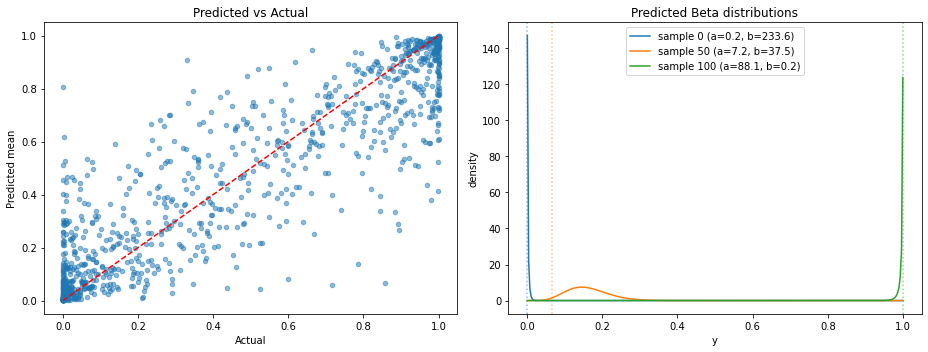

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: predictions vs actuals
ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")

# Right: predicted Beta densities for 3 test samples
ax = axes[1]
x = np.linspace(0.001, 0.999, 300)
for i in [0, 50, 100]:
    a_i, b_i = dists.alpha[i], dists.beta[i]
    pdf = scipy.stats.beta.pdf(x, a_i, b_i)
    ax.plot(x, pdf, label=f"sample {i} (a={a_i:.1f}, b={b_i:.1f})")
    ax.axvline(Y_test[i], color=ax.lines[-1].get_color(), linestyle=":", alpha=0.5)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Predicted Beta distributions")
ax.legend()

plt.tight_layout()
plt.show()